In [94]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_absolute_error, mean_squared_error,\
    confusion_matrix, plot_confusion_matrix, classification_report,\
    accuracy_score, plot_roc_curve

from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn import decomposition

from xgboost import XGBRegressor
from xgboost import XGBClassifier

In [2]:
df_baseline = df = pd.read_csv('Output_Data\Model_1_baseline_data.csv')
df.head()

,label,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,...,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,spread_app_id,hispace_app_tags,app_second_class,app_score,u_refreshTimes,u_feedLifeCycle
0,0,3,2,16,147,2,32,6,35,312,...,6,1846,4,46,162,47,14,10.0,0,15
1,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
2,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
3,0,3,2,16,147,2,32,6,35,312,...,8,1542,4,47,152,49,17,10.0,0,15
4,0,3,2,16,147,2,32,6,35,312,...,8,1036,4,44,312,43,18,10.0,0,15


In [28]:
df_baseline_sub = df_baseline.sample(n=100000,random_state=23333)
df_baseline_sub.label.value_counts(normalize=True)

# pick one subset
# that value counts match original most

0    0.98452
1    0.01548
Name: label, dtype: float64

In [29]:
df_baseline_sub.shape

(100000, 24)

In [7]:
df = pd.read_csv('Output_Data\data_subset_engineered_for_model.csv')
df.head()

,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,...,pt_d_hour,age_outstanding,device_size_cat,residence_cat,series_dev_outstanding,age_out_dev_big,age_out_dev_norm,great_big_dev,great_nom_dev,ad_click_list_v001_len
0,0,122942,8,2,41,135,5,16,5,20,...,2,2,3,3,2,0,0,0,0,5
1,0,120972,7,2,41,412,2,21,4,12,...,5,2,1,3,2,0,0,0,0,5
2,0,176028,7,2,45,435,2,16,5,19,...,10,2,1,3,2,0,0,0,0,5
3,0,166112,3,2,20,328,5,32,6,29,...,8,1,3,3,2,1,0,0,0,5
4,0,123102,7,2,24,431,5,30,3,35,...,10,2,1,3,2,0,0,0,0,5


In [8]:
df.shape

(100000, 35)

# BASELINE MODEL

In [30]:
X = df_baseline_sub.drop(columns='label')
y = df_baseline_sub.label

X_baseline_sub_train, X_baseline_sub_test, y_baseline_sub_train, y_baseline_sub_test = train_test_split(X, y, test_size=0.2, random_state=2333)

X_baseline_sub_train.shape, X_baseline_sub_test.shape

((80000, 23), (20000, 23))

In [42]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_baseline_sub_train_resampled, y_baseline_sub_train_resampled = smote.fit_resample(X_baseline_sub_train, y_baseline_sub_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_baseline_sub_train_resampled).value_counts()) 

Original class distribution: 

0    98452
1     1548
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    78764
0    78764
Name: label, dtype: int64


- desicion tree

In [103]:
std_slc = StandardScaler()
dec_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])

criterion = ['gini', 'entropy']
max_depth = np.arange(10,22,2)
min_samples_split = np.arange(2,11,4)
min_samples_leaf = np.arange(1,11,5)

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__min_samples_leaf=min_samples_leaf)


tree_baseline_GS = GridSearchCV(pipe, parameters, scoring='f1')
tree_baseline_GS.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)


GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': array([10, 12, 14, 16, 18, 20]),
                         'dec_tree__min_samples_leaf': array([1, 6]),
                         'dec_tree__min_samples_split': array([ 2,  6, 10])},
             scoring='f1')

20k data, takes 13.3s

100k data, takes 15.2s

78764 * 2 data, takes 35.3s

above for depth 2-12

78764 * 2 data, takes 2m 10.9s

last try 6m



In [105]:
print('Best Criterion:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_split:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', tree_baseline_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])
print(); 
print(tree_baseline_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: gini
Best max_depth: 20
Best min_samples_split: 6
Best min_samples_leaf: 1

DecisionTreeClassifier(max_depth=20, min_samples_split=6)


In [107]:
tree_baseline_best_model = tree_baseline_GS.best_estimator_
tree_baseline_best_model.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('dec_tree',
                 DecisionTreeClassifier(max_depth=20, min_samples_split=6))])

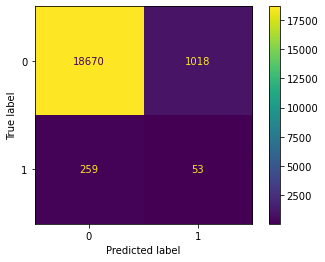

In [108]:
plot_confusion_matrix(tree_baseline_best_model,X_baseline_sub_test, y_baseline_sub_test)

In [109]:
print(classification_report(y_baseline_sub_test, tree_baseline_best_model.predict(X_baseline_sub_test)))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     19688
           1       0.05      0.17      0.08       312

    accuracy                           0.94     20000
   macro avg       0.52      0.56      0.52     20000
weighted avg       0.97      0.94      0.95     20000



In [110]:
print(classification_report(y_baseline_sub_train, tree_baseline_best_model.predict(X_baseline_sub_train)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     78764
           1       0.30      0.70      0.42      1236

    accuracy                           0.97     80000
   macro avg       0.65      0.84      0.70     80000
weighted avg       0.98      0.97      0.98     80000



Conclusion:
- after hyper tuning, it still works bad for test
- after all, decision tree doesn't work well for imbalanced data, but it's so bad

- balanced random forest

In [84]:
BRFC_clf = BalancedRandomForestClassifier(random_state=2333)
BRFC_clf.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled) 

BalancedRandomForestClassifier(random_state=2333)

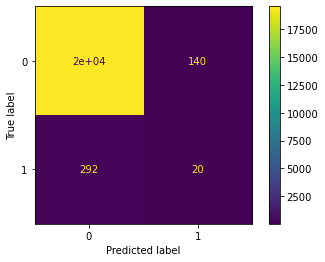

In [86]:
plot_confusion_matrix(BRFC_clf, X_baseline_sub_test, y_baseline_sub_test)

In [85]:
print(classification_report(y_baseline_sub_test, BRFC_clf.predict(X_baseline_sub_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19688
           1       0.12      0.06      0.08       312

    accuracy                           0.98     20000
   macro avg       0.56      0.53      0.54     20000
weighted avg       0.97      0.98      0.97     20000



In [83]:
std_slc = StandardScaler()
brf_clf = BalancedRandomForestClassifier()

brf_pipe = Pipeline(steps=[('std_slc', std_slc), ('brf_clf', brf_clf)])

brf_params = {'model__n_estimators': [100,200] , 'model__min_samples_leaf': [1,3]}

rf_GS = GridSearchCV(estimator = brf_pipe, param_grid = brf_params, cv = 5)
rf_GS.fit(X_baseline_sub_train_resampled, y_baseline_sub_train_resampled)

rf_GS.best_params_

ValueError: Invalid parameter model for estimator Pipeline(steps=[('std_slc', StandardScaler()),
                ('brf_clf', BalancedRandomForestClassifier())]). Check the list of available parameters with `estimator.get_params().keys()`.

# 2nd model

In [89]:
X = df.drop(columns='label')
y = df.label

X_2_sub_train, X_2_sub_test, y_2_sub_train, y_2_sub_test = train_test_split(X, y, test_size=0.2, random_state=2333)
X_2_sub_train.shape, X_2_sub_test.shape

((80000, 34), (20000, 34))

In [90]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_2_sub_train_resampled, y_2_sub_train_resampled = smote.fit_resample(X_2_sub_train, y_2_sub_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_2_sub_train_resampled).value_counts()) 

Original class distribution: 

0    98452
1     1548
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    78764
0    78764
Name: label, dtype: int64


- decision tree

In [91]:
std_slc = StandardScaler()
dec_tree = DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc), ('dec_tree', dec_tree)])

criterion = ['gini', 'entropy']
max_depth = np.arange(10,22,2)
min_samples_split = np.arange(10,40,10)
min_samples_leaf = np.arange(10,40,10)

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__min_samples_leaf=min_samples_leaf)


In [92]:
tree_2_GS = GridSearchCV(pipe, parameters)
tree_2_GS.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': array([10, 12, 14, 16, 18, 20]),
                         'dec_tree__min_samples_leaf': array([10, 20, 30]),
                         'dec_tree__min_samples_split': array([10, 20, 30])})

In [93]:
print('Best Criterion:', tree_2_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', tree_2_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_split:', tree_2_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', tree_2_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])
print(); 
print(tree_2_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: entropy
Best max_depth: 20
Best min_samples_split: 20
Best min_samples_leaf: 10

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=10,
                       min_samples_split=20)


In [96]:
tree_2_best_model = tree_2_GS.best_estimator_
tree_2_best_model.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('dec_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        min_samples_leaf=10,
                                        min_samples_split=20))])

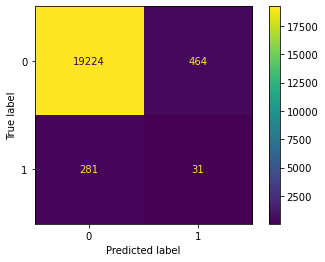

In [98]:
plot_confusion_matrix(tree_2_best_model,X_2_sub_test, y_2_sub_test)

In [99]:
print(classification_report(y_2_sub_test, tree_2_best_model.predict(X_2_sub_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19688
           1       0.06      0.10      0.08       312

    accuracy                           0.96     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.97      0.96      0.97     20000



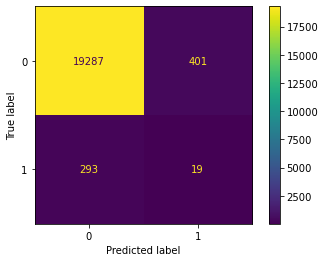

In [6]:
plot_confusion_matrix(tree_clf_raw,X_test, y_test)

In [7]:
print(classification_report(y_test, tree_clf_raw.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19688
           1       0.05      0.06      0.05       312

    accuracy                           0.97     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.97      0.97      0.97     20000



- xgboost

In [101]:
params = {'max_depth': [3,4, 5], 'learning_rate': [.1, .3, .5],
          'gamma': [0,5,10], 'n_estimators': [50,100, 150] }

xg_2_cv = GridSearchCV(estimator = XGBRegressor(objective='reg:squarederror'), scoring='neg_mean_absolute_error',
                  param_grid = params, cv = 5)
                  
xg_2_cv.fit(X_2_sub_train_resampled, y_2_sub_train_resampled);

KeyboardInterrupt: 

In [ ]:
xg_2_cv.best_estimator_

In [ ]:
best_mod = xg_2_cv.best_estimator_
best_mod.fit(X_2_sub_train_resampled.reshape(-1,1), y_2_sub_train_resampled);
y_pred = best_mod.predict(X_2_sub_test)

In [ ]:
total_preds = best_mod.predict(X_train)

In [9]:
logreg_baseline_pipe = Pipeline([
    ('OHE', OneHotEncoder(sparse = False, drop = 'first')), 
    ('model', LogisticRegression(random_state=2333))
    ])

logreg_baseline_pipe

Pipeline(steps=[('OHE', OneHotEncoder(drop='first', sparse=False)),
                ('model', LogisticRegression(random_state=2333))])

In [11]:
logreg_baseline_pipe.fit(X_train, y_train)

MemoryError: Unable to allocate 25.7 GiB for an array with shape (80000, 43037) and data type float64